# Access ERA5 data from NCAR's Geoscience Data Exchange (GDEX) and compute anomaly

## Overview

ERA-5 Dataset is available from NCAR's GDEX in netcdf format as hourly files. A subset of this dataset is processed into Zarr format and available from NCAR GDEX endpoints. To learn how you can create Zarr files from NCAR GDEX netcdf files, please see [this notebook](./05_data_preprocessing.ipynb).


In this notebook, 
* We will read data zarr stores from NCAR's GDEX endpoint 
* Compute temperature anomaly for the years 1940-2023

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Intro to Xarray](https://foundations.projectpythia.org/core/xarray) | Necessary | |
| [Intro to Intake](https://projectpythia.org/intake-cookbook/notebooks/intake_introduction) | Necessary | |
| [Understanding of Zarr](https://zarr.readthedocs.io/en/stable/) | Helpful | |

- **Time to learn**: 30 minutes

## Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import intake_esm
import intake
import pandas as pd
import cartopy.crs as ccrs  # Correct import for coordinate reference systems
import cartopy.feature as cfeature
from holoviews import opts
import geoviews as gv
import holoviews as hv
import aiohttp

### Specify global variables

In [2]:
baseline_year_start = 1940
baseline_year_end   = 1949
current_year  = 2023

In [3]:
#
gdex_scratch   = "/lustre/desc1/scratch/harshah"
#
era5_catalog = 'https://data.gdex.ucar.edu/special_projects/pythia_2024/pythia_intake_catalogs/era5_catalog.json'
annual_means      = '/gdex/data/special_projects/pythia_2024/annual_means/' #Posix path, only used for writing data 
annual_means_https= 'https://data.gdex.ucar.edu/special_projects/pythia_2024/annual_means/'

print(era5_catalog)

https://data.gdex.ucar.edu/special_projects/pythia_2024/pythia_intake_catalogs/era5_catalog.json


### Create a Dask cluster

#### Dask Introduction

[Dask](https://www.dask.org/) is a solution that enables the scaling of Python libraries. It mimics popular scientific libraries such as numpy, pandas, and xarray that enables an easier path to parallel processing without having to refactor code. 

There are 3 components to parallel processing with Dask: the client, the scheduler, and the workers. 

The Client is best envisioned as the application that sends information to the Dask cluster. In Python applications this is handled when the client is defined with `client = Client(CLUSTER_TYPE)`. A Dask cluster comprises of a single scheduler that manages the execution of tasks on workers. The `CLUSTER_TYPE` can be defined in a number of different ways.

- There is LocalCluster, a cluster running on the same hardware as the application and sharing the available resources, directly in Python with `dask.distributed`. 

- In certain JupyterHubs Dask Gateway may be available and a dedicated dask cluster with its own resources can be created dynamically with `dask.gateway`. 

- On HPC systems `dask_jobqueue` is used to connect to the HPC Slurm and PBS job schedulers to provision resources.

The `dask.distributed` client python module can also be used to connect to existing clusters. A Dask Scheduler and Workers can be deployed in containers, or on Kubernetes, without using a Python function to create a dask cluster. The `dask.distributed` Client is configured to connect to the scheduler either by container name, or by the Kubernetes service name.     

#### Select the Dask cluster type

The default will be `LocalCluster` as that can run on any system.

If running on a HPC computer with a PBS Scheduler, set to True. Otherwise, set to False.

In [4]:
USE_PBS_SCHEDULER = False

If running on Jupyter server with Dask Gateway configured, set to True. Otherwise, set to False.

In [5]:
USE_DASK_GATEWAY = False

**Python function for a PBS Cluster**

In [6]:
# Create a PBS cluster object
def get_pbs_cluster():
    """ Create cluster through dask_jobqueue.   
    """
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster(
        job_name = 'dask-pythia-24',
        cores = 1,
        memory = '4GiB',
        processes = 1,
        local_directory = gdex_scratch + '/dask/spill',
        resource_spec = 'select=1:ncpus=1:mem=4GB',
        queue = 'casper',
        walltime = '1:00:00',
        #interface = 'ib0'
        interface = 'ext'
    )
    return cluster

**Python function for a Gateway Cluster**

In [7]:
def get_gateway_cluster():
    """ Create cluster through dask_gateway
    """
    from dask_gateway import Gateway

    gateway = Gateway()
    cluster = gateway.new_cluster()
    cluster.adapt(minimum=2, maximum=4)
    return cluster

**Python function for a Local Cluster**

In [8]:
def get_local_cluster():
    """ Create cluster using the Jupyter server's resources
    """
    from distributed import LocalCluster, performance_report
    cluster = LocalCluster()    

    cluster.scale(4)
    return cluster

**Python logic to select the Dask Cluster type**

This uses True/False boolean logic based on the variables set in the previous cells

In [9]:
# Obtain dask cluster in one of three ways

if USE_PBS_SCHEDULER:
    cluster = get_pbs_cluster()
elif USE_DASK_GATEWAY:
    cluster = get_gateway_cluster()
else:
    cluster = get_local_cluster()

# Connect to cluster
from distributed import Client
client = Client(cluster)

# Display cluster dashboard URL
cluster

LocalCluster(2b292600, 'tcp://127.0.0.1:45611', workers=4, threads=16, memory=15.16 GiB)

### Open ERA5 annual means file

In [10]:
temp_2m_annual = xr.open_zarr(annual_means_https + 'temp_2m_annual_1940_2023.zarr').VAR_2T
temp_2m_annual 

<xarray.DataArray 'VAR_2T' (time: 84, latitude: 721, longitude: 1440)> Size: 349MB
dask.array<open_dataset-VAR_2T, shape=(84, 721, 1440), dtype=float32, chunksize=(84, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 672B 1940-12-31 1941-12-31 ... 2023-12-31
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    167
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          2 metre temperature
    maximum_value:                                      320.42938232421875
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric surf...
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    short_name:                                         2t
    units:                                              K

In [11]:
baseline_temp = temp_2m_annual.sel(time= \
                                   temp_2m_annual.time.dt.year.isin(range(baseline_year_start, baseline_year_end+1))).mean('time')
baseline_temp 

<xarray.DataArray 'VAR_2T' (latitude: 721, longitude: 1440)> Size: 4MB
dask.array<mean_agg-aggregate, shape=(721, 1440), dtype=float32, chunksize=(721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8

In [12]:
temp_anomaly = temp_2m_annual - baseline_temp
temp_anomaly

<xarray.DataArray 'VAR_2T' (time: 84, latitude: 721, longitude: 1440)> Size: 349MB
dask.array<sub, shape=(84, 721, 1440), dtype=float32, chunksize=(84, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 672B 1940-12-31 1941-12-31 ... 2023-12-31

### Save anomaly

In [13]:
# %%time
# temp_anomaly.to_dataset().to_zarr(annual_means + 'temp_anomaly_wrt_1940_1950.zarr')

In [14]:
temp_anomaly = xr.open_zarr(annual_means_https + 'temp_anomaly_wrt_1940_1950.zarr').VAR_2T
temp_anomaly

<xarray.DataArray 'VAR_2T' (time: 84, latitude: 721, longitude: 1440)> Size: 349MB
dask.array<open_dataset-VAR_2T, shape=(84, 721, 1440), dtype=float32, chunksize=(84, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 672B 1940-12-31 1941-12-31 ... 2023-12-31

- Plot the temperature anomaly

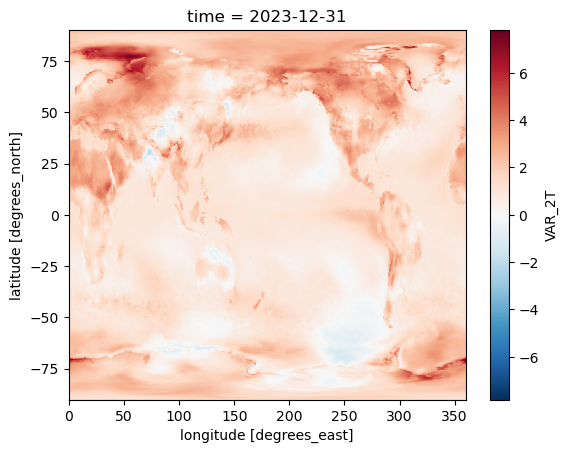

In [15]:
temp_anomaly.isel(time=83).plot()

## Close the Dask Cluster

It's best practice to close the Dask cluster when it's no longer needed to free up the compute resources used.

In [16]:
cluster.close()